### Loading the packages and the Gym Environment 

In [ ]:
import os
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import time
from envs import TradingEnv

def cost(delta_h, multiplier):
    TickSize = 0.1
    return multiplier * TickSize * (np.abs(delta_h) + 0.01 * delta_h**2)


### Getting the cost of hedging distribution using the cost given in Du et al. 

In [ ]:
vol = 0.01 * np.sqrt(250)

bs_env = TradingEnv(continuous_action_flag=True, sabr_flag=False, 
                    dg_random_seed= 1, spread=0.005, num_contract=1, 
                    init_ttm=10, trade_freq=0.2, num_sim= 10000,
                        mu =0, vol = vol, S = 100, K = 100, r = 0, q = 0)



delta_path = bs_env.delta_path*100
delta_path = np.insert(delta_path, 0, 0, axis=1)
delta_h = np.diff(delta_path, axis=1)
transaction_costs = cost(delta_h, multiplier=5)

total_costs = np.sum(transaction_costs, axis =1)




# df = pd.DataFrame({"Sample Path ": np.arange(1, 11), "Total Cost" : total_costs})
# with open("hedging_costs_table.tex", "w") as f:
#     f.write(df.to_latex(index=False))

sns.set_style("whitegrid")
# Plot histogram for the distribution of total hedging costs
plt.figure(figsize=(10, 5))
sns.histplot(total_costs, bins=10, kde=True, color="orange")
plt.xlabel("Total Hedging Cost")
plt.ylabel("Frequency")
plt.title("Distribution of Total Hedging Costs")
plt.savefig("bsdelta_plots/hedging_costs_hist_small_dt.png")
plt.show()

# Box plot to identify outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=total_costs, color="orange")
plt.xlabel("Total Hedging Cost")
plt.title("Box Plot of Total Hedging Costs (Outliers Detection)")
plt.savefig("bsdelta_plots/hedging_costs_boxplot_small_dt.png")
plt.show()


In [ ]:

outlier_cost = 315
high_cost_indices = np.where(total_costs > outlier_cost)
low_cost_indices = np.where(total_costs <= outlier_cost)

# When costs are high
fig, axs = plt.subplots(2, 1, figsize=(10, 10 ))

axs[0].plot(bs_env.delta_path[ 658, :], label="Delta Sample Path", color="orange")
axs[0].plot(bs_env.gamma_path[ 658, :], label="Gamma Path", color="blue")
axs[0].set_xlabel("TimeStep")
axs[0].set_ylabel("Values")
axs[0].set_title("Delta & Gamma Path when costs are high")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(bs_env.path[ 658, :], label="Stock Price", color="green")
axs[1].set_xlabel("TimeStep")
axs[1].set_ylabel("Values")
axs[1].set_title("Stock Price when costs are high")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.savefig("bsdelta_plots/Delta_Gamma_High")
plt.show()

# When costs are low
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(bs_env.delta_path[1, :], label="Delta", color="orange")
axs[0].plot(bs_env.gamma_path[1, :], label="Gamma", color="blue")
axs[0].set_xlabel("TimeStep")
axs[0].set_ylabel("Values")
axs[0].set_title("Delta & Gamma Path when costs are not high")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(bs_env.path[1, :], label="Stock Price", color="green")
axs[1].set_xlabel("TimeStep")
axs[1].set_ylabel("Values")
axs[1].set_title("Stock Price when costs are not high")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.savefig("bsdelta_plots/Delta_Gamma_Low")
plt.show()

In [ ]:
from scipy.stats import ks_2samp

avg_gamma = np.average(bs_env.gamma_path, axis = 1)

high_cost_gamma= avg_gamma[high_cost_indices]
low_cost_gamma = avg_gamma[low_cost_indices]
num_path = len(high_cost_gamma)
sns.set_style("whitegrid")
# Plot histogram for the distribution of total hedging costs
plt.figure(figsize=(10, 5))
sns.kdeplot(high_cost_gamma, color="red", label = f"High Cost TC > {outlier_cost}", shade = False)
sns.kdeplot(low_cost_gamma, color="green", label = f"Not Highw Cost TC <= {outlier_cost}", shade = False)
plt.legend()
plt.xlabel("Average Gamma")
plt.ylabel("Density")
plt.title("Distribution of Average Gamma")
plt.savefig("bsdelta_plots/High_vs_Low Hedging Cost Gamma dist.png")
plt.show()

ks_statistic , p_value = ks_2samp(low_cost_gamma, high_cost_gamma)

print(f"Kolmogorov–Smirnov Statistic: {ks_statistic}")
print(f"P-value: {p_value}")
 
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. The two samples come from different distributions.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to suggest different distributions.")

### Testing Rebalancing Frequency on Hedging Cost

In [ ]:
rebalance_frequencies = [1,2,5,10]  
colors = ["blue", "green", "orange", "red"]  # Different colors for each distribution
num_simulations = 10000

plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")

for i, freq in enumerate(rebalance_frequencies):
    # Create environment with given rebalancing frequency
    bs_env = TradingEnv(continuous_action_flag=True, sabr_flag=False, 
                        dg_random_seed=1, spread=0.01, num_contract=1, 
                        init_ttm=10, trade_freq=1/freq, num_sim=num_simulations,
                        mu=0, vol=0.01, S=100, K=100, r=0, q=0)

    # Compute total hedging cost
    delta_path = bs_env.delta_path * 100
    delta_path = np.insert(delta_path, 0, 0, axis=1)
    delta_h = np.diff(delta_path, axis=1)
    transaction_costs = cost(delta_h, multiplier=5)
    total_costs = np.sum(transaction_costs, axis=1)

    # Plot KDE for the current rebalancing frequency
    sns.kdeplot(total_costs, label=f"{freq} trades/day", color=colors[i], linewidth=2)

# Graph formatting
plt.xlabel("Total Hedging Cost")
plt.ylabel("Density")
plt.title("Effect of Rebalancing Frequency on Hedging Costs")
plt.legend()
plt.savefig("hedging_costs_Rebalancing.png")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black-Scholes delta calculation for call options
def black_scholes_delta_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    return delta

# Parameters
S = np.linspace(50, 150, 100)  # Range of underlying asset prices
K = 100  # Strike price
T = 1  # Time to maturity (10 days)
r = 0  # Risk-free interest rate
volatilities = [0.1, 0.2, 0.3, 0.4, 0.5]  # Different levels of volatility

# Plot delta for different levels of volatility
plt.figure(figsize=(10, 6))
for sigma in volatilities:
    delta_call_values = black_scholes_delta_call(S, K, T, r, sigma)
    plt.plot(S, delta_call_values, label=f'Volatility = {sigma}')

plt.axvline(x=K, color='black', linestyle='--', label='Strike Price (ATM)')
plt.xlabel('Underlying Asset Price')
plt.ylabel('Delta')
plt.title('Delta as a Function of Underlying Asset Price for Different Volatilities')
plt.legend()
plt.grid(True)
plt.savefig("bsdelta_plots/bs_delta_stock_price.png")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black-Scholes delta calculation for call options
def black_scholes_delta_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    return delta

# Parameters
S = np.linspace(50, 150, 100)  # Range of underlying asset prices
K = 100  # Strike price
r = 0  # Risk-free interest rate
sigma = 0.2  # Constant volatility
times_to_maturity = [10/252, 30/252, 60/252, 90/252, 180/252]  # Different times to maturity (in years)

# Plot delta for different times to maturity
plt.figure(figsize=(10, 6))
for T in times_to_maturity:
    delta_call_values = black_scholes_delta_call(S, K, T, r, sigma)
    plt.plot(S, delta_call_values, label=f'Time to Maturity = {T*252:.0f} days')

plt.axvline(x=K, color='black', linestyle='--', label='Strike Price (ATM)')
plt.xlabel('Underlying Asset Price')
plt.ylabel('Delta')
plt.title('Delta as a Function of Underlying Asset Price for Different Times to Maturity')
plt.legend()
plt.grid(True)
plt.savefig("bsdelta_plots/bs_delta_time_to_maturity.png")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black-Scholes gamma calculation
def black_scholes_gamma(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    return gamma

# Parameters
S = np.linspace(50, 150, 100)  # Range of underlying asset prices
K = 100  # Strike price
T = 200/252 # Time to maturity (1 year)
r = 0.05  # Risk-free interest rate
volatilities = [0.05, 0.2, 0.3, 0.4, 0.5]  # Different levels of volatility

# Plot gamma for different levels of volatility
plt.figure(figsize=(10, 6))
for sigma in volatilities:
    gamma_values = black_scholes_gamma(S, K, T, r, sigma)
    plt.plot(S, gamma_values, label=f'Volatility = {sigma}')

plt.axvline(x=K, color='red', linestyle='--', label='Strike Price (ATM)')
plt.xlabel('Underlying Asset Price')
plt.ylabel('Gamma')
plt.title('Gamma as a Function of Underlying Asset Price for Different Volatilities')
plt.legend()
plt.grid(True)
plt.savefig("bsdelta_plots/bs_gamma_vol.png")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black-Scholes gamma calculation
def black_scholes_gamma(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    return gamma

# Parameters
S = np.linspace(50, 150, 100)  # Range of underlying asset prices
K = 100  # Strike price
r = 0.05  # Risk-free interest rate
sigma = 0.2  # Constant volatility
times_to_maturity = [10/252, 30/252, 60/252, 90/252, 180/252]  # Different times to maturity (in years)

# Plot gamma for different times to maturity
plt.figure(figsize=(10, 6))
for T in times_to_maturity:
    gamma_values = black_scholes_gamma(S, K, T, r, sigma)
    plt.plot(S, gamma_values, label=f'Time to Maturity = {T*252:.0f} days')

plt.axvline(x=K, color='red', linestyle='--', label='Strike Price (ATM)')
plt.xlabel('Underlying Asset Price')
plt.ylabel('Gamma')
plt.title('Gamma as a Function of Underlying Asset Price for Different Times to Maturity')
plt.legend()
plt.grid(True)
plt.savefig("bsdelta_plots/bs_gamma_time_to_maturity.png")
plt.show()

# Total Profit & Loss Analysis 

In [13]:
from scipy.stats import kstest,shapiro
from scipy.stats import skew, kurtosis

vol = 0.01 * np.sqrt(250)

bs_env = TradingEnv(continuous_action_flag=True, sabr_flag=False, 
                dg_random_seed= None , spread=0.005, num_contract=1, 
                init_ttm=10, trade_freq=1/5, num_sim= 10000,
                    mu =0, vol = vol, S = 100, K = 100, r = 0, q = 0)


delta_path = bs_env.delta_path*100
delta_path_append = np.insert(delta_path, 0, 0, axis=1)
delta_h = np.diff(delta_path_append, axis=1)
delta_h= delta_h[:, :-1]
transaction_costs = cost(delta_h, multiplier=0)
total_costs = np.sum(transaction_costs, axis =1)

num_ops = 100
#option value V_t 
v_t = bs_env.option_price_path*num_ops
v_t_diff = np.diff(v_t, axis=1)

#hedged position value 
s_t = bs_env.path
s_t_diff = np.diff(s_t, axis=1)
a_t = delta_path[:, :-1]
h_t = a_t*s_t_diff

#total pnl_t 
pi_t = v_t_diff - h_t - transaction_costs

total_pnl = np.sum(pi_t, axis = 1)


1. generate asset price paths
2. generate BS price and delta
simulation done!


In [ ]:
sns.set_style("whitegrid")
# Plot histogram for the distribution of total hedging costs
plt.figure(figsize=(10, 5))
sns.kdeplot(total_pnl, color="orange")
plt.xlabel("Total Hedging PnL")
plt.ylabel("Frequency")
plt.xlim(-100, 100)
plt.title("Distribution of Total PnL")
plt.savefig("bsdelta_plots/hedging_total_pnl_Cost5.png")
plt.show()

# Box plot to identify outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=total_pnl, color="orange")
plt.xlabel("Total  PnL")
plt.title("Box Plot of Total PnL (Outliers Detection)")
plt.savefig("bsdelta_plots/hedging_total_pnl_boxplot_Cost_5.png")
plt.show()


# Kolmogorov-Smirnov Test
ks_stat, ks_p = kstest(total_pnl, 'norm', args=(np.mean(total_pnl), np.std(total_pnl)))
print(f"Kolmogorov-Smirnov Test: Statistic = {ks_stat}, p-value = {ks_p}")

shapiro_stat, shapiro_p = shapiro(total_pnl)
print(f"Shapiro-Wilk Test: Statistic = {shapiro_stat}, p-value = {shapiro_p}")


skewness = skew(total_pnl)
kurt = kurtosis(total_pnl)
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurt}")


1. generate asset price paths
2. generate BS price and delta
simulation done!
Kolmogorov-Smirnov Test: Statistic = 0.039603388320745836, p-value = 4.5910613795594584e-14
1. generate asset price paths
2. generate BS price and delta
simulation done!
Kolmogorov-Smirnov Test: Statistic = 0.04218678785518226, p-value = 6.676326848832263e-16
1. generate asset price paths
2. generate BS price and delta
simulation done!
Kolmogorov-Smirnov Test: Statistic = 0.03735236834648148, p-value = 1.4728953202723524e-12
1. generate asset price paths
2. generate BS price and delta
simulation done!
Kolmogorov-Smirnov Test: Statistic = 0.03907004801131536, p-value = 1.0635748347605581e-13


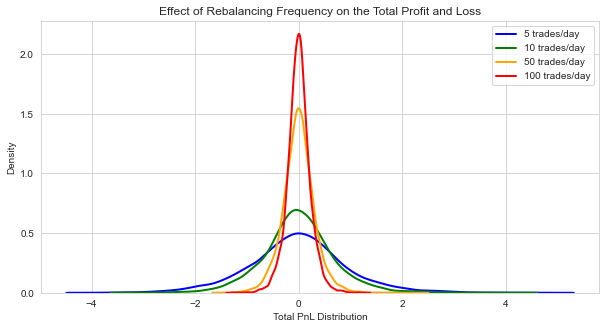

In [11]:
"""
determing the distribution when the transactions costs are zero
it is seeming to me now that when the transaction costs are zero then the pnl is just equal to the hedging error.
the hedging error is the difference between the option value and the hedged position value.
"""

rebalance_frequencies = [5,10,50,100]  
colors = ["blue", "green", "orange", "red"]  # Different colors for each distribution
num_simulations = 10000

plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")

for i, freq in enumerate(rebalance_frequencies):
    # Create environment with given rebalancing frequency
    bs_env = TradingEnv(continuous_action_flag=True, sabr_flag=False, 
                        dg_random_seed=1, spread=0.01, num_contract=1, 
                        init_ttm=10, trade_freq=1/freq, num_sim=num_simulations,
                        mu=0, vol=0.01, S=100, K=100, r=0, q=0)

    delta_path = bs_env.delta_path*100
    delta_path_append = np.insert(delta_path, 0, 0, axis=1)
    delta_h = np.diff(delta_path_append, axis=1)
    delta_h= delta_h[:, :-1]
    transaction_costs = cost(delta_h, multiplier=0)
    total_costs = np.sum(transaction_costs, axis =1)

    num_ops = 100
    #option value V_t 
    v_t = bs_env.option_price_path*num_ops
    v_t_diff = np.diff(v_t, axis=1)

    #hedged position value 
    s_t = bs_env.path
    s_t_diff = np.diff(s_t, axis=1)
    a_t = delta_path[:, :-1]
    h_t = a_t*s_t_diff

    #total pnl_t 
    pi_t = v_t_diff - h_t - transaction_costs

    total_pnl = np.sum(pi_t, axis = 1)
    ks_stat, ks_p = kstest(total_pnl, 'norm', args=(np.mean(total_pnl), np.std(total_pnl)))
    print(f"Kolmogorov-Smirnov Test: Statistic = {ks_stat}, p-value = {ks_p}")

    # Plot KDE for the current rebalancing frequency
    sns.kdeplot(total_pnl, label=f"{freq} trades/day", color=colors[i], linewidth=2)

# Graph formatting
plt.xlabel("Total PnL Distribution")
plt.ylabel("Density")
plt.title("Effect of Rebalancing Frequency on the Total Profit and Loss")
plt.legend()
plt.savefig("hedging_pnl_Rebalancing.png")
plt.show()

In [45]:
import matplotlib.animation as animation
pnl_high = 0.1
pnl_low = -0.1
zero_pnl_indices = np.where((total_pnl<pnl_high) & (total_pnl>pnl_low)) 
low_pnl_indices = np.where(total_pnl<pnl_low)

# Sample indices (replace with your actual indices)
indices = zero_pnl_indices[0]  
print(indices)

[  92  321  375  477  556  600  680  729  867  969 1045 1124 1257 1589
 1636 2143 2196 2219 2296 2299 2414 2480 2636 2957 3124 3386 3393 3492
 3677 3838 3974 4052 4448 4504 4588 4737 4756 4803 4825 4859 5185 5364
 5477 5613 5639 5690 5854 5942 6011 6023 6090 6458 6559 6989 7076 7109
 7150 7200 7213 7382 7395 7487 7596 7701 8037 8260 8341 8592 8697 8804
 8853 8992 9152 9255 9260 9284 9402 9514 9589 9839 9934 9998]


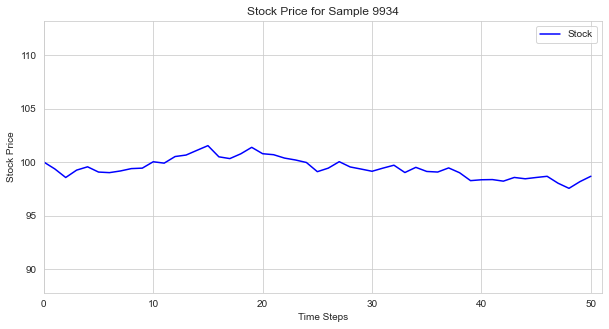

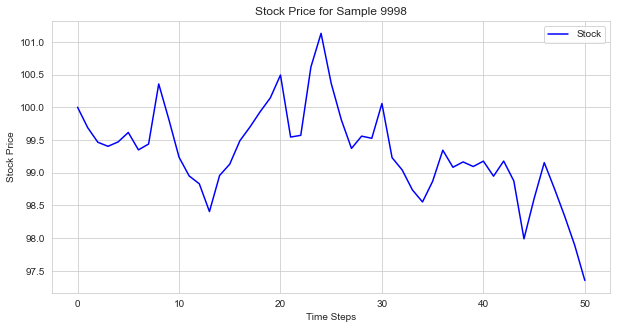

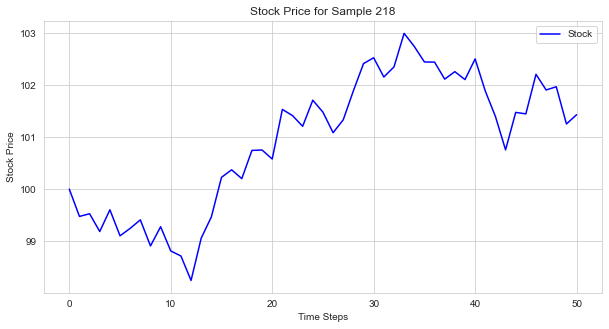

In [52]:
import matplotlib.animation as animation
pnl_high = 0.05
pnl_low = -0.05
high_pnl_indices = np.where(total_pnl>pnl_high)
low_pnl_indices = np.where(total_pnl<pnl_low)
zero_pnl_indices = np.where((total_pnl<pnl_high) & (total_pnl>pnl_low)) 

# Sample indices (replace with your actual indices)
indices = zero_pnl_indices[0]  

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 5))
line, = ax.plot([], [], color="blue", label="Stock")

# Set axis labels
ax.set_xlabel("Time Steps")
ax.set_ylabel("Stock Price")
ax.legend()

# Set axis limits based on data
ax.set_xlim(0, s_t.shape[1])  # X-axis limit based on number of timesteps
ax.set_ylim(np.min(s_t), np.max(s_t))  # Y-axis limit based on stock prices

# Initialization function
def init():
    line.set_data([], [])
    return line,

# Update function for animation
def update(i):
    x_data = np.arange(s_t.shape[1])  # Time steps
    y_data = s_t[indices[i], :]  # Stock price for current sample
    
    line.set_data(x_data, y_data)  
    ax.set_title(f"Stock Price for Sample {indices[i]}")
    
    return line,

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(indices), init_func=init, interval=500, blit=False)

ani.save("bsdelta_plots/stock_zero_pnl.gif", writer="pillow", fps=2)  # Uncomment to save as GIF

plt.show()

#Single plot for a specific sample
plt.figure(figsize=(10,5))
plt.plot(s_t[4588, :], label="Stock", color="blue")
plt.title("Stock Price for Sample 9998")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.savefig("bsdelta_plots/stock__pnl_9998.png")
plt.show()  

#Single plot for a specific sample
plt.figure(figsize=(10,5))
plt.plot(s_t[4737, :], label="Stock", color="blue")
plt.title("Stock Price for Sample 218")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.savefig("bsdelta_plots/stock__pnl_218.png")
plt.show()  

In [ ]:
# Calculate cumulative hedging costs for high and low PnL scenarios
high_pnl_costs = np.sum(cost(delta_h[high_pnl_indices], multiplier=5), axis=1)
low_pnl_costs = np.sum(cost(delta_h[low_pnl_indices], multiplier=5), axis=1)

# Plot cumulative costs
plt.figure(figsize=(10, 5))
sns.kdeplot(high_pnl_costs, label="Relatively High PnL Cost", color="blue", fill=True)
sns.kdeplot(low_pnl_costs, label="Relatively high PnL Cost", color="orange", fill=True)
plt.xlabel("Cumulative Hedging Costs")
plt.ylabel("Density")
plt.title("Comparison of Hedging Costs for High and Low PnL Scenarios")
plt.legend()
plt.savefig("bsdelta_plots/hedging_costs_high_vs_low_pnl.png")
plt.show()

In [ ]:
# Calculate moneyness (stock price / strike price)
moneyness_high = s_t[high_pnl_indices] /100
moneyness_low = s_t[low_pnl_indices] / 100

# Plot moneyness distribution
plt.figure(figsize=(10, 5))
sns.kdeplot(moneyness_high.flatten(), label="Relatively High PnL Moneyness", color="blue", fill=True)
sns.kdeplot(moneyness_low.flatten(), label="Relatively Low PnL Moneyness", color="orange", fill=True)
plt.xlabel("Moneyness (Stock Price / Strike Price)")
plt.ylabel("Density")
plt.title("Moneyness Distribution for High and Low PnL Scenarios")
plt.legend()
plt.grid(True)
plt.savefig("bsdelta_plots/moneyness_high_vs_low_pnl.png")
plt.show()

In [ ]:
std_pi_t = np.std(pi_t, axis = 1)
n = pi_t.shape[1]

t_statistic = np.sqrt(n)*(np.mean(pi_t, axis = 1))/std_pi_t

# Plot the distribution of pi_t
plt.figure(figsize=(8, 5))
sns.kdeplot(t_statistic, fill=True, color="orange", label="Student t-statistic of Total PnL")
plt.xlabel("Student t-statistic of Total PnL")
plt.ylabel("Density")
plt.title("Density Plot Student t-statistic of Total PnL")

x_ticks = np.arange(-10,6, 2)  # Adjust range as needed
plt.xticks(x_ticks)

plt.legend()
plt.savefig("bsdelta_plots/hedging_total_pnl_tstat_Cost5")
plt.show()

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute per-step changes in PnL
pnl_diff = np.diff(pi_t, axis=1)  # Shape (10000, T-1)

# Compute realized volatility per simulation
realized_volatility = np.std(pi_t, axis=1)

# Plot density of realized volatility
plt.figure(figsize=(8, 5))
sns.kdeplot(realized_volatility, fill=True, color="orange", label="Realized Volatility of Total PnL")
plt.xlabel("Realized Volatility of Total PnL")
plt.ylabel("Density")
plt.title("Density Plot of Realized Volatility of Total PnL")

# Set x-axis ticks every 5 steps
x_ticks = np.arange(0, np.max(realized_volatility) + 10, 5)  # Adjust range as needed
plt.xticks(x_ticks)

plt.legend()
plt.savefig("bsdelta_plots/hedging_total_pnl_vol_Cost5")
plt.show()

from scipy.stats import skew, kurtosis
skewness = skew(realized_volatility)
kurt = kurtosis(realized_volatility)
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurt}")


In [ ]:
inds1= np.where(realized_volatility > 10)
inds2 = np.where(realized_volatility <= 4)


plt.figure(figsize=(10, 5))
sns.kdeplot(total_pnl[inds1], label="Total cost dist Realized Volatility > 7", color="blue", fill=True)
sns.kdeplot(total_pnl[inds2], label="Total cost dist Realized Volatility > 7", color="orange", fill=True)
plt.show()

In [ ]:
ind = 279
len_j= v_t_diff.shape[1]
option_pnl = []
stock_pnl =[]
total_pnl = []

#Calculate the cummulative option and stock pnl. 
for j in range(len_j):
    if j ==0:
        option_pnl.append(v_t_diff[ind,j])
        stock_pnl.append(-h_t[ind,j]-transaction_costs[ind,j])
        total_pnl.append(v_t_diff[ind,j]-h_t[ind,j]-transaction_costs[ind,j])
    else: 
        option_pnl.append(v_t_diff[ind,j] + option_pnl[j-1])
        stock_pnl.append(-h_t[ind,j]-transaction_costs[ind, j]+ stock_pnl[j-1] )
        total_pnl.append(v_t_diff[ind,j] + option_pnl[j-1]-h_t[ind,j]-transaction_costs[ind, j]+ stock_pnl[j-1] )



fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# First subplot: Option PnL, Stock PnL, Total PnL, and Delta
axs[0].plot(option_pnl, label="Option PnL", color="red")
axs[0].plot(stock_pnl, label="Stock PnL", color="green")
axs[0].plot(total_pnl, label="Total PnL", color="black")
axs[0].plot(-delta_path[ind, :-1], label="Delta", color="orange")
axs[0].grid(True)
axs[0].legend()
axs[0].set_title("PnL and Delta Path")
axs[0].set_xlabel("Time Steps")
axs[0].set_ylabel("PnL / Delta")

# Second subplot: Stock Price
axs[1].plot(s_t[ind, :], label="Stock Price", color="blue")
axs[1].grid(True)
axs[1].legend()
axs[1].set_title("Stock Price Path")
axs[1].set_xlabel("Time Steps")
axs[1].set_ylabel("Stock Price")

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("bsdelta_plots/OOS_PnL_and_Stock_Price_High_Vol.png")
plt.show()

In [ ]:
delta_itm= []
delta_atm = []
delta_otm = []

stock_positions= np.arange(-20, -110, -10)

for i, pos in enumerate(stock_positions):
    delta_itm.append(-100-pos)
    delta_atm.append(-50-pos)
    delta_otm.append(-pos)


plt.figure(figsize=(10, 7))
plt.plot(stock_positions, delta_itm, label="ITM Delta", color="green", linestyle = "dashdot")
plt.plot(stock_positions,delta_atm, label="ATM Delta", color="blue", linestyle = "dashed")
plt.plot(stock_positions,delta_otm, label="OTM Delta", color="red", linestyle = "dotted")
plt.xlim(-15, -105)
plt.text(-5, max(delta_otm) * 0.9, "Long", fontsize=14, color="black",)  # Positive side
plt.text(-5, min(delta_itm) * 0.9, "Short", fontsize=14, color="black",) 
plt.xlabel("stock positions")
plt.ylabel("Actions", fontsize = 14)
plt.title("Black Scholes Delta Policy Plot")
plt.grid(True)
plt.legend()
plt.savefig("bsdelta_plots/Black_Scholes_Delta_Policy_Plot.png")
plt.show()

